In [17]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import scipy as sp
import pandas as pd
import itertools
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

In [18]:
pos = [5, 8.5, 15, 21.5]
combinations = list(itertools.product(pos, repeat=4))
df = pd.DataFrame(combinations, columns=["pos1", "pos2", "pos3", "pos4"])

# Add index columns
df["pos1_idx"] = df["pos1"].map({5: 1, 8.5: 2, 15: 3, 21.5: 4})
df["pos2_idx"] = df["pos2"].map({5: 1, 8.5: 2, 15: 3, 21.5: 4})
df["pos3_idx"] = df["pos3"].map({5: 1, 8.5: 2, 15: 3, 21.5: 4})
df["pos4_idx"] = df["pos4"].map({5: 1, 8.5: 2, 15: 3, 21.5: 4})

df["CM_x"] = df["pos1"] - df["pos3"]
df["CM_y"] = df["pos4"] - df["pos2"]
df["CM_r"] = np.sqrt(df["CM_x"]**2 + df["CM_y"]**2)
df["CM_phi"] = np.arctan2(df["CM_y"], df["CM_x"])
df["cos_CM_phi"] = np.cos(df["CM_phi"])

df["MoI"] = (df["pos1"]**2 + df["pos2"]**2 + df["pos3"]**2 + df["pos4"]**2)/4


# scale MoI and CM_r to -1 1
MoI_max, MoI_min = df["MoI"].max(), df["MoI"].min()
def scale_MoI(x):
    return 2 * (x - MoI_min) / (MoI_max - MoI_min) - 1
CM_r_max, CM_r_min = df["CM_r"].max(), df["CM_r"].min()
def scale_CM_r(x):
    return 2 * (x - CM_r_min) / (CM_r_max - CM_r_min) - 1
CM_cos_phi_max, CM_cos_phi_min = df["cos_CM_phi"].max(), df["cos_CM_phi"].min()
def scale_CM_cos_phi(x):
    return 2 * (x - CM_cos_phi_min) / (CM_cos_phi_max - CM_cos_phi_min) - 1
df["MoI"] = df["MoI"].apply(scale_MoI)
df["CM_r"] = df["CM_r"].apply(scale_CM_r)
df["cos_CM_phi"] = df["cos_CM_phi"].apply(scale_CM_cos_phi)

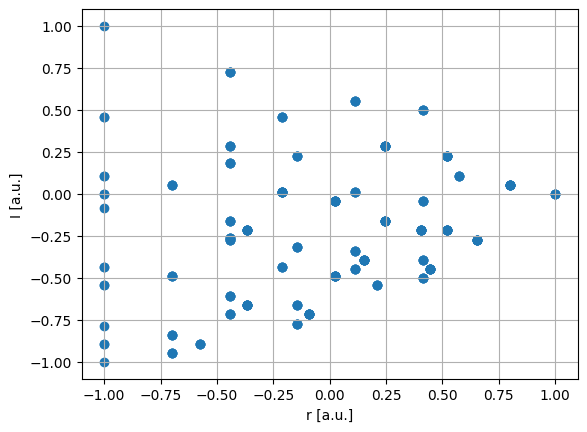

In [19]:
plt.figure()
plt.scatter(df["CM_r"], df["MoI"])
plt.xlabel("r [a.u.]")
plt.ylabel("I [a.u.]")
# plt.title("Moment of Inertia vs Center of Mass Radius")
plt.grid()
plt.savefig("MoI_vs_CMr.png")
plt.show()

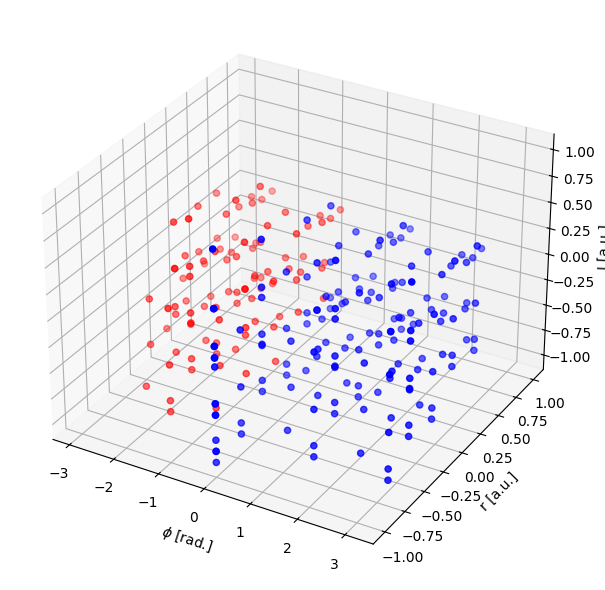

In [20]:
# Assuming your dataframe is named df
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
color = np.where(df["CM_phi"]>=0, "blue", "red")

ax.scatter(df["CM_phi"], df["CM_r"], df["MoI"], c=color, marker='o')

# Labels
ax.set_ylabel("r [a.u.]")
ax.set_xlabel("$\\phi$ [rad.]")
ax.set_zlabel("I [a.u.]")
# ax.set_title("3D Scatter Plot of CM_r, CM_phi, and MoI")
plt.tight_layout()
plt.savefig("3D_scatter_CMr_CMphi_MoI.png")
plt.show()

Best D-optimal design points:
        CM_r       MoI
0  -0.700015 -0.945969
2   0.414214 -0.500000
29  0.414214  0.500000
44 -0.442886  0.728702


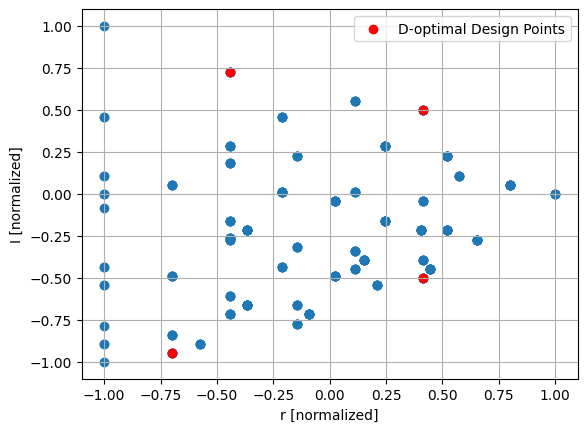

In [21]:
def d_optimal_design_vectorized(df, n_points=4, model='interaction'):

    # ---- Build model matrix ----
    if model == 'linear':
        X = np.column_stack([np.ones(len(df)), df['CM_r'], df['MoI']])
    elif model == 'interaction':
        X = np.column_stack([np.ones(len(df)), df['CM_r'], df['MoI'], df['MoI'] * df['CM_r']])
    elif model == 'quadratic':
        X = np.column_stack([np.ones(len(df)), df['CM_r'], df['MoI'],  df['MoI'] * df['CM_r'], df['CM_r']**2, df['MoI']**2])
    else:
        raise ValueError("model must be 'linear' or 'interaction'")

    n_candidates = len(df)

    # ---- Generate all combinations of n_points from the candidate set ----
    combos = np.array(list(itertools.combinations(range(n_candidates), n_points)))

    # ---- Vectorized determinant computation ----
    # Stack the X matrices for each subset: shape (n_samples, n_points, n_features)
    X_sub = X[combos]  # advanced indexing

    # Compute X'X for each subset (batched matmul)
    XtX = np.einsum('sni,snj->sij', X_sub, X_sub)

    # Compute determinants for all subsets
    dets = np.linalg.det(XtX)

    # ---- Select best subset ----
    best_idx = np.argmax(dets)
    best_det = dets[best_idx]
    best_points = df.iloc[combos[best_idx]]

    return best_points, combos[best_idx], best_det

# pick all unique combinations of r_CM and I in df
df_2D = df[['CM_r', 'MoI']].drop_duplicates().reset_index(drop=True)
# only take points with r>3
df_2D = df_2D[df_2D['CM_r'] > -1].reset_index(drop=True)

best_points, best_indices, best_det = d_optimal_design_vectorized(df_2D, n_points=4, model='interaction')
print("Best D-optimal design points:")
print(best_points)

df['isBest'] = False
for _, row in best_points.iterrows():
    mask = (np.isclose(df['CM_r'], row['CM_r'], atol=1e-6)) & (np.isclose(df['MoI'], row['MoI'], atol=1e-6))
    df.loc[mask, 'isBest'] = True

plt.figure()
plt.scatter(df["CM_r"], df["MoI"])
plt.scatter(best_points["CM_r"], best_points["MoI"], color='red', label="D-optimal Design Points")
plt.xlabel("r [normalized]")
plt.ylabel("I [normalized]")
plt.legend()
plt.grid()
plt.savefig("MoI_vs_CMr_with_Doptimal.png")
plt.show()

In [22]:
# Create an interactive 3D scatter plot with hover information
fig = px.scatter_3d(df, 
                    x='CM_r', 
                    y='CM_phi', 
                    z='MoI',
                    color='isBest',
                    color_discrete_map={False: 'blue', True: 'red'},
                    hover_data=['pos1', 'pos2', 'pos3', 'pos4'],
                    title='Domain',
                    labels={
                        'CM_r': 'Center of Mass Radius',
                        'CM_phi': 'Center of Mass Angle (radians)',
                        'MoI': 'Moment of Inertia'
                    })

# Customize the appearance
fig.update_traces(marker=dict(size=5, opacity=0.8))

# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title='CM_r',
        yaxis_title='CM_phi',
        zaxis_title='MoI',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)
        )
    ),
    width=800,
    height=600,
    showlegend=False
)

fig.show()

In [23]:
df_experiment = df[df['isBest']].reset_index(drop=True)
df_experiment = df_experiment[df_experiment["CM_phi"]==0].reset_index(drop=True)
df_experiment_shuffled = df_experiment.sample(frac=1, random_state=42).reset_index(drop=True)
print(df_experiment_shuffled)

# save only pos1_idx, pos2_idx, pos3_idx, pos4_idx to csv
#df_experiment_shuffled[["pos1_idx", "pos2_idx", "pos3_idx", "pos4_idx"]].to_csv("data.csv", index=False)

   pos1  pos2  pos3  pos4  pos1_idx  pos2_idx  pos3_idx  pos4_idx  CM_x  CM_y  \
0  21.5   5.0   5.0   5.0         4         1         1         1  16.5   0.0   
1  21.5  21.5  15.0  21.5         4         4         3         4   6.5   0.0   
2   8.5   5.0   5.0   5.0         2         1         1         1   3.5   0.0   
3  21.5  21.5   5.0  21.5         4         4         1         4  16.5   0.0   

       CM_r  CM_phi  cos_CM_phi       MoI  isBest  
0  0.414214     0.0         1.0 -0.500000    True  
1 -0.442886     0.0         1.0  0.728702    True  
2 -0.700015     0.0         1.0 -0.945969    True  
3  0.414214     0.0         1.0  0.500000    True  


In [24]:
# load the data_1.csv
def read_data(file_path):
    data_1 = pd.read_csv(file_path)
    #convert pos1_idx, pos2_idx, pos3_idx, pos4_idx to positions
    data_1["pos1"] = data_1["pos1_idx"].map({1: 5, 2: 8.5, 3: 15, 4: 21.5})
    data_1["pos2"] = data_1["pos2_idx"].map({1: 5, 2: 8.5, 3: 15, 4: 21.5})
    data_1["pos3"] = data_1["pos3_idx"].map({1: 5, 2: 8.5, 3: 15, 4: 21.5})
    data_1["pos4"] = data_1["pos4_idx"].map({1: 5, 2: 8.5, 3: 15, 4: 21.5})

    data_1["CM_x"] = data_1["pos1"] - data_1["pos3"]
    data_1["CM_y"] = data_1["pos4"] - data_1["pos2"]
    data_1["CM_r"] = np.sqrt(data_1["CM_x"]**2 + data_1["CM_y"]**2)
    data_1["CM_phi"] = data_1["angle"]
    data_1["cos_CM_phi"] = np.cos(data_1["CM_phi"])

    data_1["MoI"] = (data_1["pos1"]**2 + data_1["pos2"]**2 + data_1["pos3"]**2 + data_1["pos4"]**2)/4

    # scale
    data_1["MoI"] = data_1["MoI"].apply(scale_MoI)
    data_1["CM_r"] = data_1["CM_r"].apply(scale_CM_r)
    data_1["cos_CM_phi"] = data_1["cos_CM_phi"].apply(scale_CM_cos_phi)

    print(data_1)
    return data_1
data_1 = read_data("data_1.csv")

   pos1_idx  pos2_idx  pos3_idx  pos4_idx  angle  time  pos1  pos2  pos3  \
0         4         1         1         1      0  5728  21.5   5.0   5.0   
1         4         4         3         4      0  7353  21.5  21.5  15.0   
2         2         1         1         1      0  6573   8.5   5.0   5.0   
3         4         4         1         4      0  6543  21.5  21.5   5.0   
4         4         1         1         1     45  6057  21.5   5.0   5.0   
5         4         4         3         4     45  7617  21.5  21.5  15.0   
6         2         1         1         1     45  6553   8.5   5.0   5.0   
7         4         4         1         4     10  6818  21.5  21.5   5.0   

   pos4  CM_x  CM_y      CM_r  CM_phi  cos_CM_phi       MoI  
0   5.0  16.5   0.0  0.414214       0    1.000000 -0.500000  
1  21.5   6.5   0.0 -0.442886       0    1.000000  0.728702  
2   5.0   3.5   0.0 -0.700015       0    1.000000 -0.945969  
3  21.5  16.5   0.0  0.414214       0    1.000000  0.500000  
4   5

In [25]:
def interaction(vars, a0, a1, a2, a3, a4, a5, a6):
    MoI, CM_r, CM_phi = vars
    return (
        a0 +
        a1 * MoI +
        a2 * CM_r +
        a3 * CM_phi +
        a4 * MoI * CM_r +
        a5 * MoI * CM_phi +
        a6 * CM_r * CM_phi 
        #a7 * MoI * CM_r * CM_phi

    )
names_interaction = ["a_MoI", "a_r", "a_phi", "a_MoI_r", "a_MoI_phi", "a_r_phi"]
# --- Prepare inputs ---
def fit_data(data, model_function):
    xdata = np.vstack((data["MoI"], data["CM_r"], data["cos_CM_phi"]))
    ydata = data["time"]
    sigma_time =110 * np.ones_like(ydata)

    # --- Fit with weights (errors) ---
    popt, pcov = curve_fit(
        model_function,
        xdata,
        ydata,
        sigma=sigma_time,
        absolute_sigma=True
    )

    # Extract results
    perr = np.sqrt(np.diag(pcov))
    for i, (p, e) in enumerate(zip(popt, perr)):
        print(f"a{i} = {p:.5g} ± {e:.5g}")

    # Goodness of fit
    residuals = ydata - model_function(xdata, *popt)
    chi2 = np.sum((residuals / sigma_time) ** 2)
    ndof = len(ydata) - len(popt)
    print(f"\nReduced χ² = {chi2/ndof:.3f}")
    return popt, pcov
popt_int, pcov_int = fit_data(data_1, interaction)


a0 = 6747.9 ± 92.688
a1 = 654.88 ± 185.1
a2 = -903.2 ± 231.92
a3 = -204.42 ± 114.83
a4 = -27.204 ± 144.97
a5 = 21.754 ± 226.73
a6 = 15.017 ± 289.51

Reduced χ² = 4.312


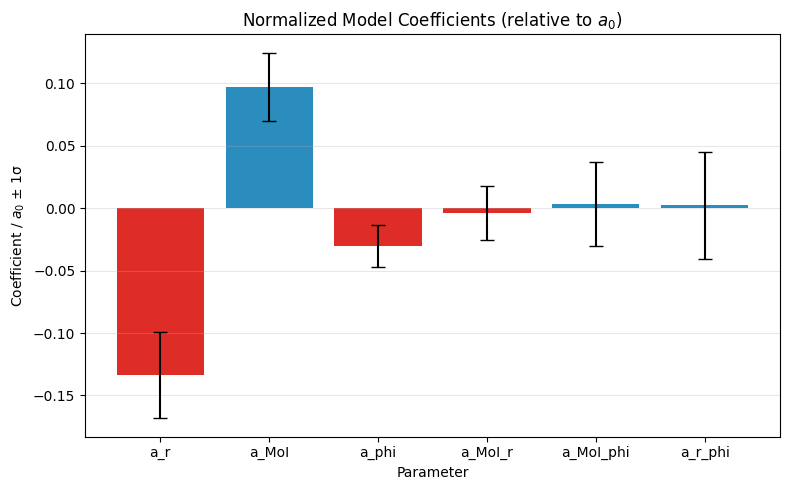

In [26]:
def plot_normalized_coefficients(popt, pcov, names):
    perr = np.sqrt(np.diag(pcov))

    # --- Normalize by a_0 ---
    normalized_values = popt[1:] / popt[0]

    # --- Propagate errors for division ---
    # For y = x/a_0: σ_y = |y| * sqrt((σ_x/x)² + (σ_a0/a0)²)
    normalized_errors = np.abs(normalized_values) * np.sqrt(
        (perr[1:] / popt[1:])**2 + (perr[0] / popt[0])**2
    )

    # --- Compute absolute effects for sorting ---
    abs_effects_norm = np.abs(normalized_values)

    # --- Sort by absolute value ---
    sort_idx = np.argsort(abs_effects_norm)[::-1]
    sorted_names = np.array(names)[sort_idx]
    sorted_values = normalized_values[sort_idx]
    sorted_errors = normalized_errors[sort_idx]

    # --- Plot ---
    plt.figure(figsize=(8, 5))
    bars = plt.bar(
        sorted_names,
        sorted_values,
        yerr=sorted_errors,
        capsize=5,
        color=["#2b8cbe" if val >= 0 else "#de2d26" for val in sorted_values],
    )
    plt.title("Normalized Model Coefficients (relative to $a_0$)")
    plt.ylabel("Coefficient / $a_0$ ± 1σ")
    plt.xlabel("Parameter")
    plt.grid(alpha=0.3, axis="y")
    plt.tight_layout()
    plt.savefig("model_coefficients_normalized.png")
    plt.show()
plot_normalized_coefficients(popt_int, pcov_int, names_interaction)


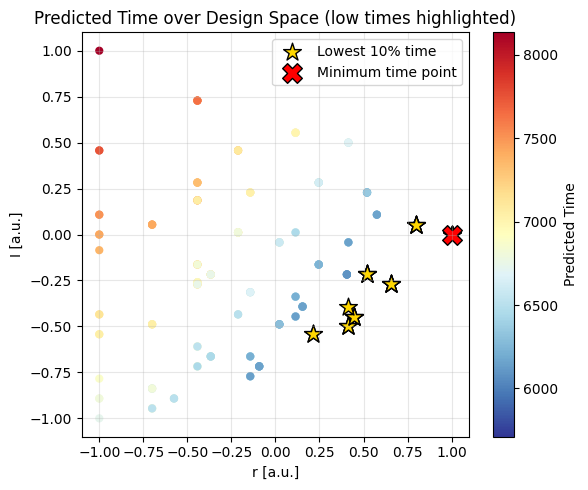

In [27]:
# evaluate all points in df based on the model (phi fixed at 0)
df['predicted_time_interaction'] = interaction(np.vstack((df["MoI"], df["CM_r"], df["cos_CM_phi"])), *popt_int)

def plot_predicted_time(df, col):
    plt.figure(figsize=(6,5))
    sc = plt.scatter(df["CM_r"], df["MoI"],
                    c=df[col],
                    cmap='RdYlBu_r',
                    s=35,
                    edgecolor='none')

    # highlight the lowest 10 (or all below 10th percentile if fewer)
    low_threshold = df[col].quantile(0.10)
    low_points = df[df[col] <= low_threshold]
    plt.scatter(low_points["CM_r"], low_points["MoI"],
                marker='*', s=180, c='gold', edgecolor='black',
                label='Lowest 10% time')

    # show lowest time point
    min_point = df.loc[df[col].idxmin()]
    plt.scatter(min_point["CM_r"], min_point["MoI"],
                marker='X', s=200, c='red', edgecolor='black',
                label='Minimum time point')

    plt.colorbar(sc, label='Predicted Time')
    plt.xlabel("r [a.u.]")
    plt.ylabel("I [a.u.]")
    plt.title("Predicted Time over Design Space (low times highlighted)")
    plt.legend(loc='upper right', frameon=True)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig("Predicted_Time_Design_Space_highlight_low.png", dpi=150)
    plt.show()
plot_predicted_time(df, 'predicted_time_interaction')

In [28]:
print(df[(np.abs(df.CM_r) < 0.1) & (np.abs(df.MoI)<0.1)].head())

     pos1  pos2  pos3  pos4  pos1_idx  pos2_idx  pos3_idx  pos4_idx  CM_x  \
43    5.0  15.0  15.0  21.5         1         3         3         4 -10.0   
58    5.0  21.5  15.0  15.0         1         4         3         3 -10.0   
142  15.0   5.0  21.5  15.0         3         1         4         3  -6.5   
163  15.0  15.0   5.0  21.5         3         3         1         4  10.0   
172  15.0  15.0  21.5   5.0         3         3         4         1  -6.5   

     CM_y     CM_r    CM_phi  cos_CM_phi       MoI  isBest  \
43    6.5  0.02225  2.565217   -0.838444 -0.042596   False   
58   -6.5  0.02225 -2.565217   -0.838444 -0.042596   False   
142  10.0  0.02225  2.147172   -0.544988 -0.042596   False   
163   6.5  0.02225  0.576375    0.838444 -0.042596   False   
172 -10.0  0.02225 -2.147172   -0.544988 -0.042596   False   

     predicted_time_interaction  
43                  6871.809902  
58                  6871.809902  
142                 6811.646836  
163                 6528.020

In [29]:
data_2 = read_data("data_2.csv")
std = data_2["time"].std()
print(std)

   pos1_idx  pos2_idx  pos3_idx  pos4_idx  angle  time  pos1  pos2  pos3  \
0         1         3         3         4   22.5  6161   5.0  15.0  15.0   
1         1         3         3         4   22.5  6361   5.0  15.0  15.0   
2         1         3         3         4   22.5  6108   5.0  15.0  15.0   
3         1         3         3         4   22.5  6250   5.0  15.0  15.0   

   pos4  CM_x  CM_y     CM_r  CM_phi  cos_CM_phi       MoI  
0  21.5 -10.0   6.5  0.02225    22.5   -0.873305 -0.042596  
1  21.5 -10.0   6.5  0.02225    22.5   -0.873305 -0.042596  
2  21.5 -10.0   6.5  0.02225    22.5   -0.873305 -0.042596  
3  21.5 -10.0   6.5  0.02225    22.5   -0.873305 -0.042596  
110.76401340989169


In [30]:
interaction([data_2["MoI"],data_2["CM_r"],data_2["cos_CM_phi"]], *popt_int)

0    6878.956975
1    6878.956975
2    6878.956975
3    6878.956975
dtype: float64

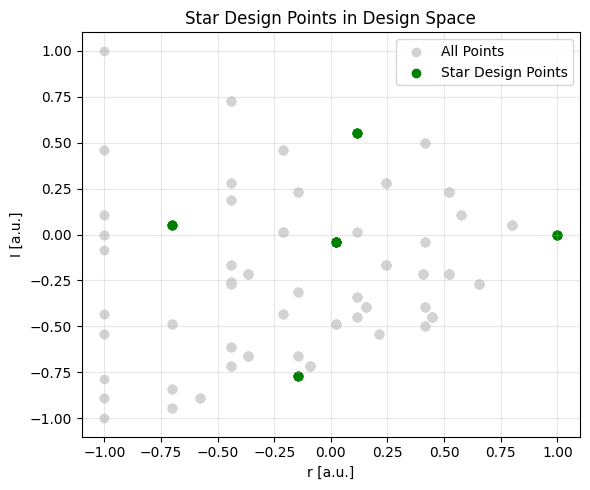

   pos1  pos2  pos3  pos4  pos1_idx  pos2_idx  pos3_idx  pos4_idx  CM_x  CM_y  \
0   5.0   5.0   5.0  15.0         1         1         1         3   0.0  10.0   
1   5.0   5.0  21.5  21.5         1         1         4         4 -16.5  16.5   
2   5.0  15.0  15.0  21.5         1         3         3         4 -10.0   6.5   
3   5.0  21.5   8.5  21.5         1         4         2         4  -3.5   0.0   
4   8.5  21.5  21.5  21.5         2         4         4         4 -13.0   0.0   

       CM_r    CM_phi  cos_CM_phi       MoI  isBest  \
0 -0.142901  1.570796    0.000000 -0.771298   False   
1  1.000000  2.356194   -0.707107  0.000000   False   
2  0.022250  2.565217   -0.838444 -0.042596   False   
3 -0.700015  3.141593   -1.000000  0.054031   False   
4  0.114229  3.141593   -1.000000  0.554031   False   

   predicted_time_interaction  isStarPoint  
0                 6368.839646         True  
1                 5978.615809         True  
2                 6871.809902         True  
3 

In [31]:
# Select star design points for second order by hand
df["isStarPoint"] = False
df.loc[(np.abs(df["MoI"]) < 0.1) & (df["CM_r"] < -0.6) & (df["CM_r"] > -1), "isStarPoint"] = True
df.loc[(np.abs(df["MoI"]) < 0.1) & (df["CM_r"] > 0.9), "isStarPoint"] = True
df.loc[(np.abs(df["CM_r"]) < 0.25) & (df["MoI"] > 0.5), "isStarPoint"] = True
df.loc[(np.abs(df["CM_r"]) < 0.25) & (df["MoI"] < -0.75), "isStarPoint"] = True
df.loc[(np.abs(df["CM_r"]) < 0.1) & (np.abs(df["MoI"]) < 0.1), "isStarPoint"] = True



plt.figure(figsize=(6,5))
plt.scatter(df["CM_r"], df["MoI"], c='lightgray', label='All Points')
plt.scatter(df[df["isStarPoint"]]["CM_r"], df[df["isStarPoint"]]["MoI"],
            color='green', label='Star Design Points')
plt.xlabel("r [a.u.]")
plt.ylabel("I [a.u.]")
plt.title("Star Design Points in Design Space")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

df_experiment2 = df[df['isStarPoint']].reset_index(drop=True)
# select only unique rows in MoI and CM_r, but keep all columns
df_experiment2 = df_experiment2.drop_duplicates(subset=['MoI', 'CM_r']).reset_index(drop=True)
# df_experiment_shuffled2 = df_experiment2.sample(frac=1, random_state=42).reset_index(drop=True)
# print(df_experiment_shuffled2)

# save only pos1_idx, pos2_idx, pos3_idx, pos4_idx to csv, add angles by hand
# df_experiment2[["pos1_idx", "pos2_idx", "pos3_idx", "pos4_idx"]].to_csv("data_3.csv", index=False)
print(df_experiment2)

   pos1_idx  pos2_idx  pos3_idx  pos4_idx  angle  time  pos1  pos2  pos3  \
0         1         1         1         3   22.5  5595   5.0   5.0   5.0   
1         1         1         4         4   22.5  5491   5.0   5.0  21.5   
2         1         3         3         4   45.0  6684   5.0  15.0  15.0   
3         1         3         3         4    0.0  6015   5.0  15.0  15.0   
4         1         4         2         4   22.5  6984   5.0  21.5   8.5   
5         2         4         4         4   22.5  6356   8.5  21.5  21.5   

   pos4  CM_x  CM_y      CM_r  CM_phi  cos_CM_phi       MoI  
0  15.0   0.0  10.0 -0.142901    22.5   -0.873305 -0.771298  
1  21.5 -16.5  16.5  1.000000    22.5   -0.873305  0.000000  
2  21.5 -10.0   6.5  0.022250    45.0    0.525322 -0.042596  
3  21.5 -10.0   6.5  0.022250     0.0    1.000000 -0.042596  
4  21.5  -3.5   0.0 -0.700015    22.5   -0.873305  0.054031  
5  21.5 -13.0   0.0  0.114229    22.5   -0.873305  0.554031  
a0 = 6749.8 ± 92.632
a1 = 882.36 

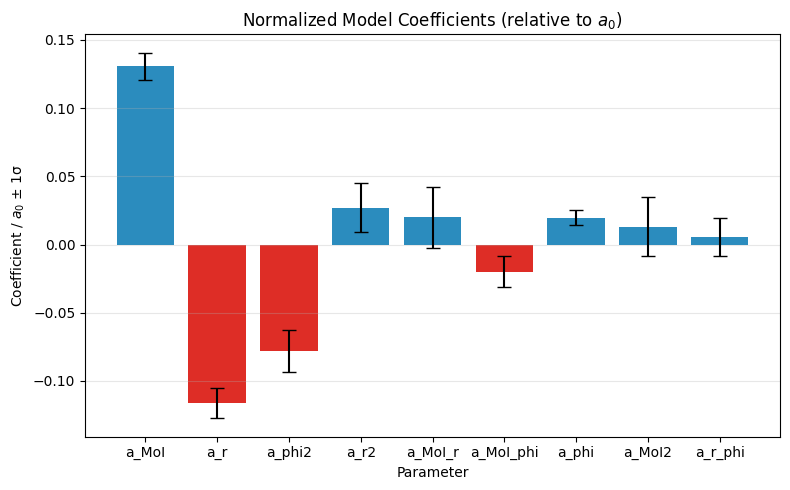

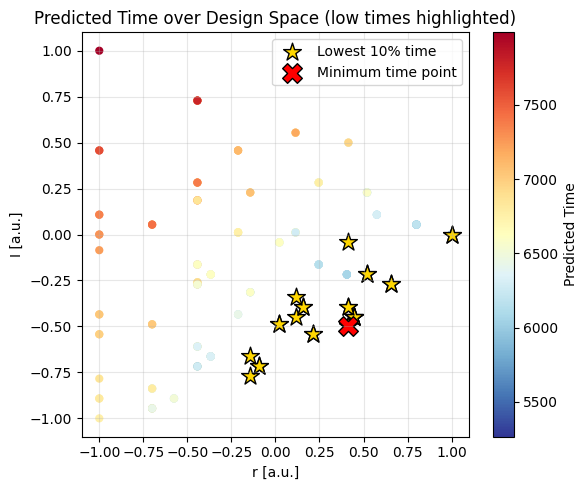

In [32]:
data_3 = read_data("data_3.csv")
data_all = pd.concat([data_1, data_2, data_3], ignore_index=True)
def quadratic(vars, a0, a1, a2, a3, a4, a5, a6, a7, a8, a9):
    MoI, CM_r, CM_phi = vars
    return (
        a0 +
        a1 * MoI +
        a2 * CM_r +
        a3 * CM_phi +
        a4 * MoI * CM_r +
        a5 * MoI * CM_phi +
        a6 * CM_r * CM_phi +
        a7 * MoI**2 +
        a8 * CM_r**2 +
        a9 * CM_phi**2
    )
names_quadratic = ["a_MoI", "a_r", "a_phi", "a_MoI_r", "a_MoI_phi", "a_r_phi", "a_MoI2", "a_r2", "a_phi2"]

popt_quad, pcov_quad = fit_data(data_all, quadratic)
plot_normalized_coefficients(popt_quad, pcov_quad, names_quadratic)

df['predicted_time_quadratic'] = quadratic(np.vstack((df["MoI"], df["CM_r"], df["cos_CM_phi"])), *popt_quad)
plot_predicted_time(df, 'predicted_time_quadratic')
